In [ ]:
# Multi-Armed Bandit Problem Implementation (From Scratch)


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt, log

# Ensure reproducibility
np.random.seed(42)


In [ ]:

# Environment: Bernoulli Arm


class BernoulliArm:
    def __init__(self, p):
        self.p = p  # success probability
    
    def draw(self):
        return 1 if np.random.rand() < self.p else 0


In [ ]:

# Epsilon-Greedy Algorithm


class EpsilonGreedy:
    def __init__(self, n_arms, epsilon=0.1):
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms, dtype=int)
        self.values = np.zeros(n_arms, dtype=float)
    
    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(len(self.values))
        return np.argmax(self.values)
    
    def update(self, chosen, reward):
        self.counts[chosen] += 1
        n = self.counts[chosen]
        value = self.values[chosen]
        self.values[chosen] = value + (reward - value) / n


In [ ]:

# UCB1 Algorithm


class UCB1:
    def __init__(self, n_arms):
        self.counts = np.zeros(n_arms, dtype=int)
        self.values = np.zeros(n_arms, dtype=float)
        self.total_counts = 0
    
    def select_arm(self):
        n_arms = len(self.values)
        for a in range(n_arms):
            if self.counts[a] == 0:
                return a
        ucb_values = self.values + np.sqrt((2 * np.log(self.total_counts)) / self.counts)
        return int(np.argmax(ucb_values))
    
    def update(self, chosen, reward):
        self.counts[chosen] += 1
        self.total_counts += 1
        n = self.counts[chosen]
        value = self.values[chosen]
        self.values[chosen] = value + (reward - value) / n


In [ ]:

# Thompson Sampling Algorithm (for Bernoulli rewards)

class ThompsonSampling:
    def __init__(self, n_arms):
        self.alphas = np.ones(n_arms, dtype=float)
        self.betas = np.ones(n_arms, dtype=float)
    
    def select_arm(self):
        samples = np.random.beta(self.alphas, self.betas)
        return int(np.argmax(samples))
    
    def update(self, chosen, reward):
        self.alphas[chosen] += reward
        self.betas[chosen] += 1 - reward


In [ ]:

# Simulation Runner

def run_simulation(arms, algo_class, algo_kwargs=None, n_rounds=5000):
    n_arms = len(arms)
    algo = algo_class(n_arms, **algo_kwargs) if algo_kwargs else algo_class(n_arms)
    rewards = np.zeros(n_rounds)
    chosen_arms = np.zeros(n_rounds, dtype=int)
    
    for t in range(n_rounds):
        a = algo.select_arm()
        r = arms[a].draw()
        algo.update(a, r)
        rewards[t] = r
        chosen_arms[t] = a
    
    return rewards, chosen_arms, algo


In [ ]:

# Setup and Run Simulations


true_ps = [0.10, 0.15, 0.30, 0.25, 0.40]  # Arm 4 is best
arms = [BernoulliArm(p) for p in true_ps]
n_rounds = 5000

algos = {
    'Epsilon-Greedy (eps=0.1)': (EpsilonGreedy, {'epsilon': 0.1}),
    'UCB1': (UCB1, {}),
    'Thompson Sampling': (ThompsonSampling, {})
}

results = {}

for name, (cls, kwargs) in algos.items():
    rewards, chosen, algo = run_simulation(arms, cls, kwargs, n_rounds=n_rounds)
    cumulative_reward = np.cumsum(rewards)
    optimal_reward = np.cumsum([max(true_ps)] * n_rounds)
    regret = optimal_reward - cumulative_reward
    results[name] = {
        'rewards': rewards,
        'chosen_arms': chosen,
        'cumulative_reward': cumulative_reward,
        'regret': regret,
        'final_algo': algo
    }


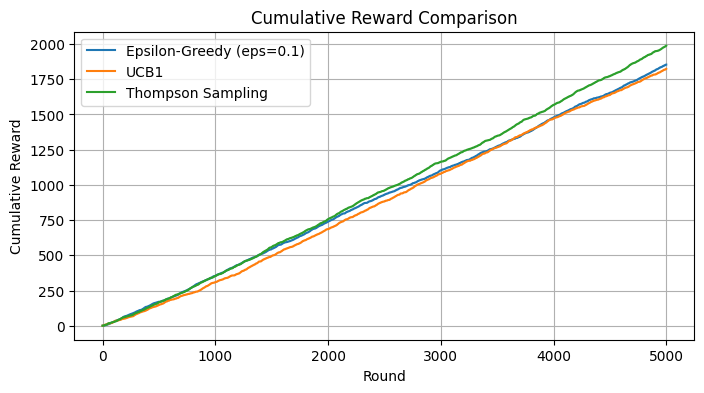

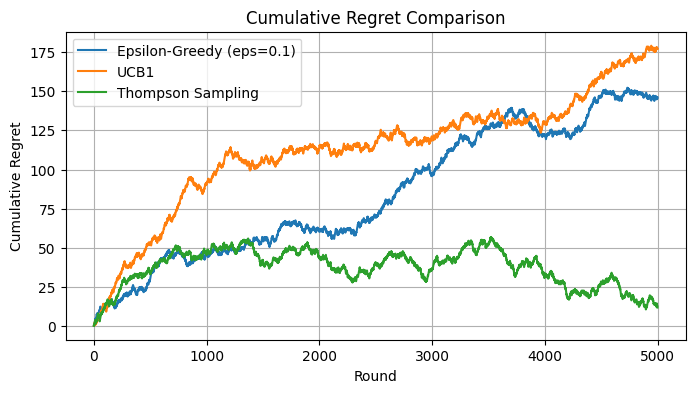

In [ ]:

# Plotting Results


plt.figure(figsize=(8,4))
for name, res in results.items():
    plt.plot(res['cumulative_reward'], label=name)
plt.xlabel('Round')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward Comparison')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,4))
for name, res in results.items():
    plt.plot(res['regret'], label=name)
plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret Comparison')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

# Summary Table


summary_rows = []

for name, res in results.items():
    algo = res['final_algo']
    if isinstance(algo, EpsilonGreedy):
        est = algo.values
        counts = algo.counts
        params = {'epsilon': algo.epsilon}
    elif isinstance(algo, UCB1):
        est = algo.values
        counts = algo.counts
        params = {}
    elif isinstance(algo, ThompsonSampling):
        est = algo.alphas / (algo.alphas + algo.betas)
        counts = (algo.alphas + algo.betas - 2).astype(int)
        params = {}
    
    summary_rows.append({
        'Algorithm': name,
        'Total Reward': int(res['cumulative_reward'][-1]),
        'Cumulative Regret': float(res['regret'][-1]),
        'Params': str(params),
        'Estimated Means': np.round(est, 4).tolist(),
        'Arm Counts': counts.tolist()
    })

df = pd.DataFrame(summary_rows)
df


,Algorithm,Total Reward,Cumulative Regret,Params,Estimated Means,Arm Counts
0,Epsilon-Greedy (eps=0.1),1854,146.0,{'epsilon': 0.1},"[0.1151, 0.1532, 0.2273, 0.2296, 0.391]","[139, 111, 88, 135, 4527]"
1,UCB1,1823,177.0,{},"[0.0917, 0.1561, 0.3075, 0.2345, 0.4034]","[120, 173, 644, 307, 3756]"
2,Thompson Sampling,1988,12.0,{},"[0.0588, 0.2063, 0.3064, 0.2672, 0.4083]","[15, 61, 171, 114, 4639]"


In [ ]:

# True Probabilities


true_df = pd.DataFrame({
    'Arm Index': list(range(len(true_ps))),
    'True Probability': true_ps
})
true_df


,Arm Index,True Probability
0,0,0.10
1,1,0.15
2,2,0.30
3,3,0.25
4,4,0.40
